In [88]:
import data
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import keras.saving
import tensorflow as tf


tickers = ['SOLUSDT', 'BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'DOGEUSDT']
models_fname = lambda x: f"models-KaggleSMA/lstm_uncertainty_variable_model_{x}.keras"


dfs = [
    data.load_asset(ticker, sampling="1d") for ticker in tickers
]

dfs = [
    data.subset(df, start=pd.Timestamp('2024-03-01'), end=pd.Timestamp('2026-01-01'))
    for df in dfs
]

dfs = [
    data.add_returns(df) for df in dfs
]

for df in dfs:
    df["Return"] = df['Return'].rolling(window=5).median()

dfs = [
    df.dropna() for df in dfs
]

@keras.saving.register_keras_serializable()
def gaussian_nll(y_true, y_pred):
    mean = y_pred[:, 0]
    log_var = y_pred[:, 1]
    precision = tf.exp(-log_var)
    return tf.reduce_mean(0.5 * (log_var + tf.square(y_true - mean) * precision))

In [50]:
import importlib
from pypfopt import EfficientFrontier, risk_models, expected_returns

historical_dfs = [
    data.load_asset(ticker, sampling="1d") for ticker in tickers
]

historical_dfs = [
    data.subset(df, start=pd.Timestamp('2022-01-01'), end=pd.Timestamp('2026-01-01'))
    for df in historical_dfs
]

historical_dfs = [
    data.add_returns(df)
    for df in historical_dfs
]

historical_dfs = [
    df.dropna() for df in historical_dfs
]


# Filter data after 2024-03-01
filtered_dfs = [
    df[df.index < pd.Timestamp('2024-03-01')] for df in historical_dfs
]

# Calculate expected returns and covariance matrix
returns = [df["Return"] for df in filtered_dfs]
opens = pd.concat([df["Open"] for df in filtered_dfs], axis=1)
opens.columns = tickers
importlib.reload(expected_returns)
mean_returns = expected_returns.mean_historical_return(opens.iloc[-365:], frequency=365)
cov_matrix = risk_models.sample_cov(opens)

# Optimize for maximum Sharpe ratio
ef = EfficientFrontier(mean_returns, cov_matrix)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()

print(cleaned_weights)


OrderedDict({'SOLUSDT': 0.91533, 'BTCUSDT': 0.08467, 'ETHUSDT': 0.0, 'XRPUSDT': 0.0, 'DOGEUSDT': 0.0})


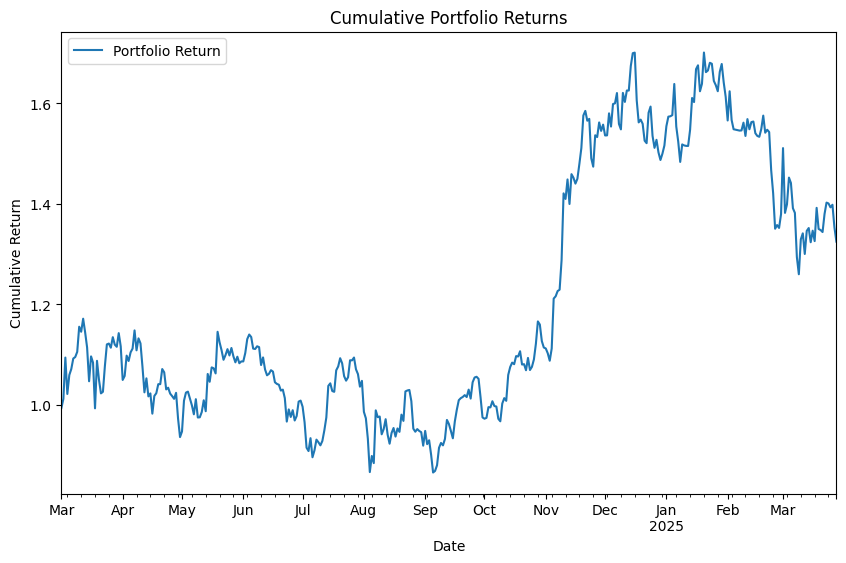

In [72]:
portfolio_returns = []

# Define the start date
start_date = pd.Timestamp('2024-03-01')

# Iterate through each day after March 1, 2024
for current_date in dfs[-1].index[dfs[-1].index > start_date]:
    # Filter data up to the current date
    data_up_to_today = opens.loc[:current_date]

    # Calculate expected returns and covariance matrix using the latest data
    mean_returns = expected_returns.mean_historical_return(data_up_to_today, frequency=365)
    cov_matrix = risk_models.sample_cov(data_up_to_today)

    # Optimize for maximum Sharpe ratio
    ef = EfficientFrontier(mean_returns, cov_matrix)
    weights = ef.max_sharpe()
    cleaned_weights = ef.clean_weights()

    # Get returns for the current day (next day's returns based on today's weights)
    daily_returns = pd.DataFrame(
        {ticker: df.loc[current_date, "Return"] for ticker, df in zip(tickers, historical_dfs)},
        index=[current_date]
    ).loc[current_date]

    # Calculate portfolio return using today's weights
    portfolio_return = np.dot(np.array(list(weights.values())), daily_returns.values)
    portfolio_returns.append(portfolio_return)

# Convert portfolio returns into a DataFrame with appropriate index
portfolio_returns_df = pd.DataFrame(portfolio_returns, index=pd.date_range(start=start_date, periods=len(portfolio_returns), freq='D'), columns=['Portfolio Return'])

# Plot the portfolio returns
(1 + portfolio_returns_df).cumprod().plot(figsize=(10, 6), title="Cumulative Portfolio Returns")
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()

In [ ]:
# optional argument: all_prices (if we need to calculate the Markowitz parameters)

import cvxpy as cp
import numpy as np

# past_prices      : array, shape (T, n), historical price series
# predicted_prices : array, shape (n,), your future price forecasts
# window           : int, look‐back window for covariance
def get_optimization_input(past_prices, predicted_prices, window=60, rf=0):
    # 1) simple returns: shape (T-1, n)
    rets = past_prices[1:] / past_prices[:-1] - 1

    # 2) expected returns over full history
    mu = np.mean(rets, axis=0)

    # 3) rolling‐window covariance: last `window` returns
    if rets.shape[0] < window:
        raise ValueError(f"Need at least {window+1} days of prices, got {past_prices.shape[0]}")
    rets_window = rets[-window:]            # shape (window, n)
    Sigma = np.cov(rets_window, rowvar=False)  # shape (n, n)

    # 4) most recent prices & implied forecast returns
    last_prices = past_prices[-1]
    r_pred = predicted_prices / last_prices - 1

    # 5) default “current” weights (equal‐weight)
    n = mu.shape[0]
    w_prev = np.ones(n) / n

    return {
        "mu": mu,                   # (n,)
        "Sigma": Sigma,             # (n, n)
        "last_prices": last_prices, # (n,)
        "r_pred": r_pred,           # (n,)
        "w_prev": w_prev,           # (n,)
        "rf": rf                    # scalar
    }

# mu               : (n,) vector of expected returns
# w_prev           : (n,) vector of current weights
# turnover_penalty : penalty coefficient (higher ⇒ smaller moves)
# long_only        : if True, enforces w >= 0
def max_return_with_turnover(mu, w_prev, turnover_penalty = 1.0, long_only = True):
    n = mu.shape[0]
    w = cp.Variable(n)

    # Objective: maximize return minus turnover penalty
    objective = cp.Maximize(
        mu @ w
        - turnover_penalty * cp.sum_squares(w - w_prev)
    )

    # Constraints
    constraints = [cp.sum(w) == 1]
    if long_only:
        constraints.append(w >= 0)

    # Solve
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.OSQP)  # OSQP handles quadratic objectives well

    if prob.status not in ["optimal", "optimal_inaccurate"]:
        raise ValueError(f"Solver did not converge: {prob.status}")

    return w.value


# mu             : (n,) vector of expected returns
# Sigma          : (n,n) covariance matrix
# risk_aversion  : lambda parameter (higher => more penalty on variance)
# long_only      : if True, enforces w >= 0
def optimize_mean_variance(mu, Sigma, risk_aversion=1.0, long_only = True):
    n = mu.shape[0]
    w = cp.Variable(n)

    # Objective: maximize return minus variance penalty
    objective = cp.Maximize(
        mu @ w
        - (risk_aversion / 2) * cp.quad_form(w, Sigma)
    )

    # Constraints: fully invested, optionally long-only
    constraints = [cp.sum(w) == 1]
    if long_only:
        constraints.append(w >= 0)

    # Solve the QP
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.OSQP)  # or cp.SCS, cp.ECOS

    if prob.status not in ["optimal", "optimal_inaccurate"]:
        raise RuntimeError(f"Solver status: {prob.status}")

    return w.value


# mu    : (n,) array of expected returns
# Sigma : (n,n) covariance matrix (must be invertible)
# rf    : risk-free rate (scalar)
def max_sharpe_ratio(mu, Sigma, rf=0.0) -> np.ndarray:
    excess = mu - rf
    inv_S = np.linalg.inv(Sigma)
    w_unnormalized = inv_S.dot(excess)
    w = w_unnormalized / np.sum(w_unnormalized)
    return w

In [93]:
from tensorflow.keras.models import load_model

models = [
    load_model(models_fname(ticker)) for ticker in tickers
]
lookback = 60

In [100]:
from sklearn.preprocessing import MinMaxScaler
import data as DATADATA

modelfolio_returns = []

# Define the start date
start_date = pd.Timestamp('2024-03-01')


predictions = []
for model, df, ticker in zip(models, historical_dfs, tickers):
    big_df = DATADATA.load_asset(ticker, sampling='1d')
    big_df = DATADATA.subset(big_df, start=pd.Timestamp('2022-01-01'), end=pd.Timestamp('2026-01-01'))
    big_df['Returns'] = big_df['Close'].pct_change()
    big_df['Returns'] = big_df['Returns'].rolling(window=5).median()
    big_df.dropna(inplace=True)
    big_data = big_df.filter(['Returns']).values


    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(big_data)
    
    # Prepare data for prediction
    input_data = [
        df["Return"].loc[:current_date].iloc[-lookback:].values
        for current_date in df.index[df.index > start_date]
    ]

    

    # Convert input_data into a numpy array with the correct shape
    # It should be of shape (batch_size, lookback, 1), where 1 represents the feature (return in this case)
    input_data = np.array(input_data)
    input_data = np.expand_dims(input_data, axis=-1)  # Shape becomes (batch_size, lookback, 1)
    input_data = np.array([scaler.transform(i.reshape(-1, 1)) for i in input_data])
    # Make predictions
    predictions.append(model.predict(input_data))


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [82]:
predictions = [
    [
        df["Return"].loc[:current_date].iloc[-lookback:].values
        for current_date in dfs[-1].index[dfs[-1].index > start_date]
    ]
    for model, df, ticker in zip(models, historical_dfs, tickers)
]

In [ ]:


# Iterate through each day after March 1, 2024
for current_date in dfs[-1].index[dfs[-1].index > start_date]:
    # Filter data up to the current date
    data_up_to_today = opens.loc[:current_date]

    # Calculate expected returns and covariance matrix using the latest data
    mean_returns = expected_returns.mean_historical_return(data_up_to_today, frequency=365)
    cov_matrix = risk_models.sample_cov(data_up_to_today)

    # Optimize for maximum Sharpe ratio
    ef = EfficientFrontier(mean_returns, cov_matrix)
    weights = ef.max_sharpe()
    cleaned_weights = ef.clean_weights()

    # Get returns for the current day (next day's returns based on today's weights)
    daily_returns = pd.DataFrame(
        {ticker: df.loc[current_date, "Return"] for ticker, df in zip(tickers, historical_dfs)},
        index=[current_date]
    ).loc[current_date]

    # Calculate portfolio return using today's weights
    portfolio_return = np.dot(np.array(list(weights.values())), daily_returns.values)
    portfolio_returns.append(portfolio_return)